In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df_clean = df.copy()

Combine Date and Time columns into a single datetime column

In [ ]:
df_clean['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %I:%M%p')

Convert Energy column to numeric, removing all suffix

In [ ]:
df_clean['Energy'] = df_clean['Energy'].str.replace('kWh', '').astype(float)
df_clean['Efficiency'] = df_clean['Efficiency'].str.replace('kWh/kW', '').astype(float)
df_clean['Power'] = df_clean['Power'].str.replace('W', '').str.replace(',', '').astype(float)
df_clean['Average'] = pd.to_numeric(df_clean['Average'].str.replace('W', '').str.replace(',', ''), errors='coerce')
df_clean['Normalised'] = pd.to_numeric(df_clean['Normalised'].str.replace('kW/kW', '').str.replace(',', ''), errors='coerce')
df_clean['Temperature'] = df_clean['Temperature'].str.replace('C', '').astype(float)
df_clean['Energy Used'] = df_clean['Energy Used'].str.replace('kWh', '').astype(float)
df_clean['Voltage'] = df_clean['Voltage'].str.replace('V', '').astype(float)
df_clean['Power Used'] = df_clean['Power Used'].str.replace('W', '').str.replace(',', '').astype(float)

In [ ]:
df_clean.set_index('DateTime', inplace=True)

Sort index to ensure chronological order

In [ ]:
df_clean.sort_index(inplace=True)

In [ ]:
df_clean = df_clean.resample('30min').last()

In [ ]:
df_clean.head()

,Date,Time,Energy,Efficiency,Power,Average,Normalised,Temperature,Voltage,Energy Used,Power Used
DateTime,,,,,,,,,,,
2024-08-15 00:00:00,15/08/2024,12:25AM,0.0,0.0,0.0,0.0,0.0,24.2,229.2,0.099,228.0
2024-08-15 00:30:00,15/08/2024,12:55AM,0.0,0.0,0.0,0.0,0.0,23.6,229.3,0.269,624.0
2024-08-15 01:00:00,15/08/2024,1:25AM,0.0,0.0,0.0,0.0,0.0,24.2,226.7,0.610,864.0
2024-08-15 01:30:00,15/08/2024,1:55AM,0.0,0.0,0.0,0.0,0.0,24.2,230.4,1.158,1128.0
2024-08-15 02:00:00,15/08/2024,2:25AM,0.0,0.0,0.0,0.0,0.0,25.3,229.8,1.503,732.0


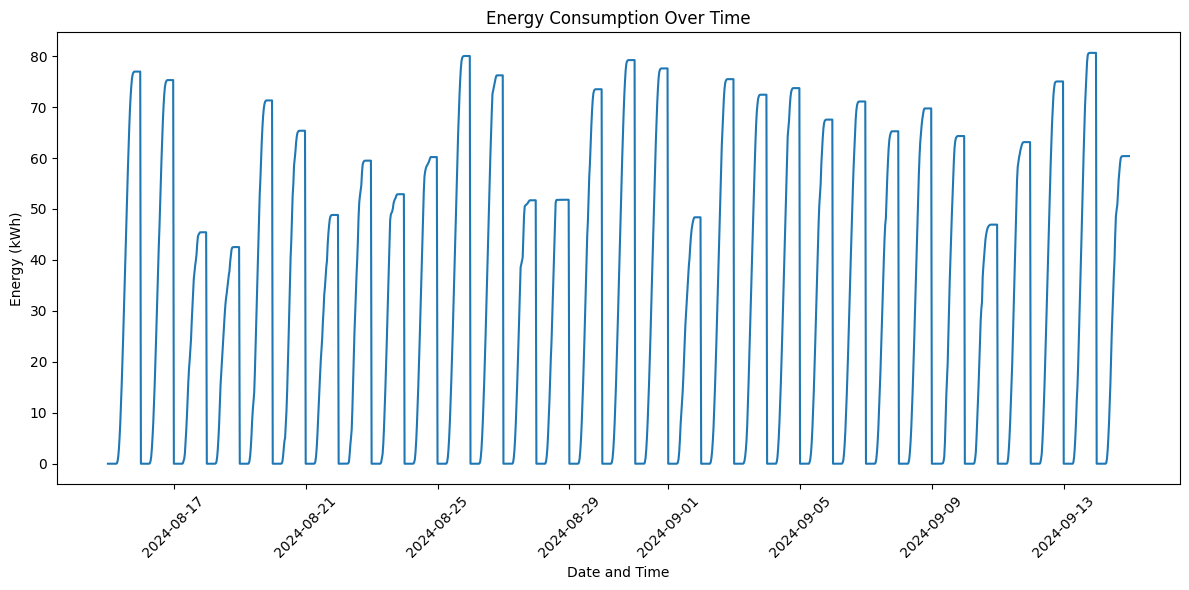

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean['Energy'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
df_clean = pd.DataFrame({
    'ds': df_clean.index,
    'y': df_clean['Energy'],
    'Efficiency': df_clean['Efficiency'],
    'Power': df_clean['Power'],
    'Average': df_clean['Average'],
    'Normalised': df_clean['Normalised'],
    'Temperature': df_clean['Temperature'],
    'Energy Used': df_clean['Energy Used'],
    'Voltage': df_clean['Voltage'],
    'Power Used': df_clean['Power Used']
})

In [ ]:
df_clean.head()

,ds,y,Efficiency,Power,Average,Normalised,Temperature,Energy Used,Voltage,Power Used
DateTime,,,,,,,,,,
2024-08-15 00:00:00,2024-08-15 00:00:00,0.0,0.0,0.0,0.0,0.0,24.2,0.099,229.2,228.0
2024-08-15 00:30:00,2024-08-15 00:30:00,0.0,0.0,0.0,0.0,0.0,23.6,0.269,229.3,624.0
2024-08-15 01:00:00,2024-08-15 01:00:00,0.0,0.0,0.0,0.0,0.0,24.2,0.610,226.7,864.0
2024-08-15 01:30:00,2024-08-15 01:30:00,0.0,0.0,0.0,0.0,0.0,24.2,1.158,230.4,1128.0
2024-08-15 02:00:00,2024-08-15 02:00:00,0.0,0.0,0.0,0.0,0.0,25.3,1.503,229.8,732.0


I will exclude 'Effciency', 'Avarage', 'Power' to reduce multicolinearity while maintaining the important predictive variables for the model

In [ ]:
def check_outliers(df, regressors=['Power', 'Temperature', 'Energy Used', 'Voltage', 'Power Used']):
    columns_to_check = ['y'] + regressors

    for column in columns_to_check:
        # Calculate z-scores
        z_scores = stats.zscore(df[column])

        # Calculate IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detect outliers
        z_score_outliers = (abs(z_scores) > 3).sum()
        iqr_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

        print(f"\n=== Outlier Analysis for {column} ===")
        print(f"Min: {df[column].min():.2f}")
        print(f"Max: {df[column].max():.2f}")
        print(f"Mean: {df[column].mean():.2f}")
        print(f"Median: {df[column].median():.2f}")
        print(f"Std Dev: {df[column].std():.2f}")

        print(f"\nOutlier Detection:")
        print(f"Z-score outliers (>3 std): {z_score_outliers} ({z_score_outliers/len(df)*100:.2f}%)")
        print(f"IQR outliers: {iqr_outliers} ({iqr_outliers/len(df)*100:.2f}%)")

        # Identify specific outlier timestamps
        if iqr_outliers > 0:
            print("\nExample Outlier Timestamps (IQR method):")
            outlier_dates = df[(df[column] < lower_bound) | (df[column] > upper_bound)]['ds'].head()
            print(outlier_dates.tolist())

        print("-" * 50)

check_outliers(df_clean)


=== Outlier Analysis for y ===
Min: 0.00
Max: 80.64
Mean: 31.38
Median: 29.09
Std Dev: 29.27

Outlier Detection:
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 0 (0.00%)
--------------------------------------------------

=== Outlier Analysis for Power ===
Min: 0.00
Max: 13053.00
Mean: 2637.54
Median: 141.50
Std Dev: 3646.81

Outlier Detection:
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 4 (0.27%)

Example Outlier Timestamps (IQR method):
[Timestamp('2024-08-21 12:00:00'), Timestamp('2024-09-09 12:30:00'), Timestamp('2024-09-14 12:00:00'), Timestamp('2024-09-14 13:00:00')]
--------------------------------------------------

=== Outlier Analysis for Temperature ===
Min: 12.20
Max: 36.90
Mean: 24.64
Median: 24.20
Std Dev: 4.51

Outlier Detection:
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 0 (0.00%)
--------------------------------------------------

=== Outlier Analysis for Energy Used ===
Min: 0.06
Max: 13.16
Mean: 4.20
Median: 3.96
Std Dev: 2.46

Outlier Detection:


In [ ]:
def handle_outliers(df_clean, columns_to_handle=['y', 'Power', 'Temperature', 'Energy Used', 'Voltage', 'Power Used']):
    # Create a copy
    df_out = df_clean.copy()

    if df_out.index.name == 'DateTime':
        df_out = df_out.reset_index()
    df_out = df_out.set_index('DateTime')  # Set DateTime as index for time interpolation

    for column in columns_to_handle:
        if column not in df_out.columns:
            print(f"Warning: Column {column} not found in DataFrame")
            continue

        # Calculate z-scores and IQR
        z_scores = stats.zscore(df_out[column])
        Q1 = df_out[column].quantile(0.25)
        Q3 = df_out[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        z_score_outliers = abs(z_scores) > 3
        iqr_outliers = (df_out[column] < lower_bound) | (df_out[column] > upper_bound)
        combined_outliers = z_score_outliers | iqr_outliers

        print(f"\n=== Handling Outliers for {column} ===")
        print(f"Z-score outliers: {z_score_outliers.sum()}")
        print(f"IQR outliers: {iqr_outliers.sum()}")
        print(f"Before - Min: {df_out[column].min():.2f}, Max: {df_out[column].max():.2f}")

        # Replace outliers with NaN
        df_out.loc[combined_outliers, column] = np.nan

        # Interpolate missing values using the datetime index
        df_out[column] = df_out[column].interpolate(method='time').ffill().bfill()

        print(f"After - Min: {df_out[column].min():.2f}, Max: {df_out[column].max():.2f}")

    # Reset index to get DateTime back as a column
    df_out = df_out.reset_index()

    return df_out

df_clean = handle_outliers(df_clean)


=== Handling Outliers for y ===
Z-score outliers: 0
IQR outliers: 0
Before - Min: 0.00, Max: 80.64
After - Min: 0.00, Max: 80.64

=== Handling Outliers for Power ===
Z-score outliers: 0
IQR outliers: 4
Before - Min: 0.00, Max: 13053.00
After - Min: 0.00, Max: 12208.00

=== Handling Outliers for Temperature ===
Z-score outliers: 0
IQR outliers: 0
Before - Min: 12.20, Max: 36.90
After - Min: 12.20, Max: 36.90

=== Handling Outliers for Energy Used ===
Z-score outliers: 11
IQR outliers: 19
Before - Min: 0.06, Max: 13.16
After - Min: 0.06, Max: 10.91

=== Handling Outliers for Voltage ===
Z-score outliers: 8
IQR outliers: 51
Before - Min: 220.90, Max: 245.00
After - Min: 225.90, Max: 239.70

=== Handling Outliers for Power Used ===
Z-score outliers: 16
IQR outliers: 222
Before - Min: 36.00, Max: 1908.00
After - Min: 36.00, Max: 600.00


In [ ]:
def make_stationary(data):
    # Create a copy of the data
    stationarity_data = data.copy()
    diff_cols = []

    # Get numeric columns excluding 'ds' (datetime)
    numeric_columns = data.select_dtypes(include=[np.number]).columns

    # Test each numeric column
    for column in numeric_columns:
        if column != 'ds':  # Extra check to skip datetime
            try:
                # Perform ADF test
                result = adfuller(data[column])

                print(f"\nTesting {column}:")
                print(f"ADF Statistic: {result[0]:.4f}")
                print(f"p-value: {result[1]:.4f}")
                print(f"Critical Values:")
                for key, value in result[4].items():
                    print(f"\t{key}: {value:.4f}")

                # If p-value > 0.05, difference the series
                if result[1] > 0.05:
                    print(f">>> {column} is NOT stationary (p-value > 0.05)")
                    print(f">>> Applying differencing to {column}")
                    stationarity_data[column] = data[column].diff()
                    diff_cols.append(column)

                    # Check stationarity after differencing
                    if stationarity_data[column].dropna().nunique() > 1:
                        result_after = adfuller(stationarity_data[column].dropna())
                        print(f"\nAfter differencing {column}:")
                        print(f"ADF Statistic: {result_after[0]:.4f}")
                        print(f"p-value: {result_after[1]:.4f}")
                else:
                    print(f">>> {column} is stationary (p-value <= 0.05)")
            except Exception as e:
                print(f"Error testing {column}: {str(e)}")

    return stationarity_data

stationary_df = make_stationary(df_clean)


Testing y:
ADF Statistic: -14.7085
p-value: 0.0000
Critical Values:
	1%: -3.4348
	5%: -2.8635
	10%: -2.5678
>>> y is stationary (p-value <= 0.05)

Testing Efficiency:
ADF Statistic: -14.7083
p-value: 0.0000
Critical Values:
	1%: -3.4348
	5%: -2.8635
	10%: -2.5678
>>> Efficiency is stationary (p-value <= 0.05)

Testing Power:
ADF Statistic: -14.0909
p-value: 0.0000
Critical Values:
	1%: -3.4348
	5%: -2.8635
	10%: -2.5678
>>> Power is stationary (p-value <= 0.05)

Testing Average:
ADF Statistic: -14.8008
p-value: 0.0000
Critical Values:
	1%: -3.4348
	5%: -2.8635
	10%: -2.5678
>>> Average is stationary (p-value <= 0.05)

Testing Normalised:
ADF Statistic: -14.8002
p-value: 0.0000
Critical Values:
	1%: -3.4348
	5%: -2.8635
	10%: -2.5678
>>> Normalised is stationary (p-value <= 0.05)

Testing Temperature:
ADF Statistic: -9.1852
p-value: 0.0000
Critical Values:
	1%: -3.4348
	5%: -2.8635
	10%: -2.5678
>>> Temperature is stationary (p-value <= 0.05)

Testing Energy Used:
ADF Statistic: -10.30

In [ ]:
# Reset index to make DateTime a regular column
df_clean = df_clean.reset_index()

# Drop one of the datetime columns (keep only 'ds')
df_clean = df_clean.drop('DateTime', axis=1)

# Scale numeric features
scaler = StandardScaler()
numerical_features = df_clean.select_dtypes(include=['number']).columns
scaled_data = pd.DataFrame(scaler.fit_transform(df_clean[numerical_features]), columns=numerical_features)

scaled_data['ds'] = df_clean['ds']

scaled_data = scaled_data.drop('index', axis=1)

In [ ]:
scaled_data.head()

,y,Efficiency,Power,Average,Normalised,Temperature,Energy Used,Voltage,Power Used,ds
0,-1.072744,-1.072747,-0.724183,-0.738453,-0.738442,-0.09864,-1.732583,-1.336366,-0.613792,2024-08-15 00:00:00
1,-1.072744,-1.072747,-0.724183,-0.738453,-0.738442,-0.23185,-1.659379,-1.299757,-0.696554,2024-08-15 00:30:00
2,-1.072744,-1.072747,-0.724183,-0.738453,-0.738442,-0.09864,-1.512540,-2.251601,-0.779315,2024-08-15 01:00:00
3,-1.072744,-1.072747,-0.724183,-0.738453,-0.738442,-0.09864,-1.276565,-0.897053,-0.862076,2024-08-15 01:30:00
4,-1.072744,-1.072747,-0.724183,-0.738453,-0.738442,0.14558,-1.128004,-1.116710,-0.944837,2024-08-15 02:00:00


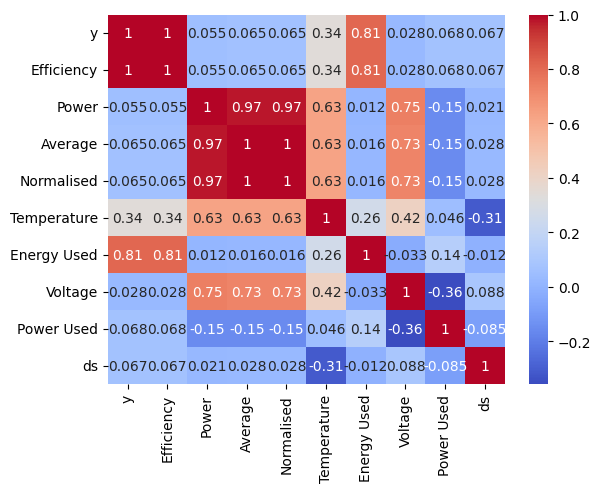

In [ ]:
sns.heatmap(scaled_data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
scaled_data = scaled_data.drop(['Efficiency', 'Average', 'Normalised'], axis=1)

Split the data into training and testing sets (80% train, 20% test)

In [ ]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

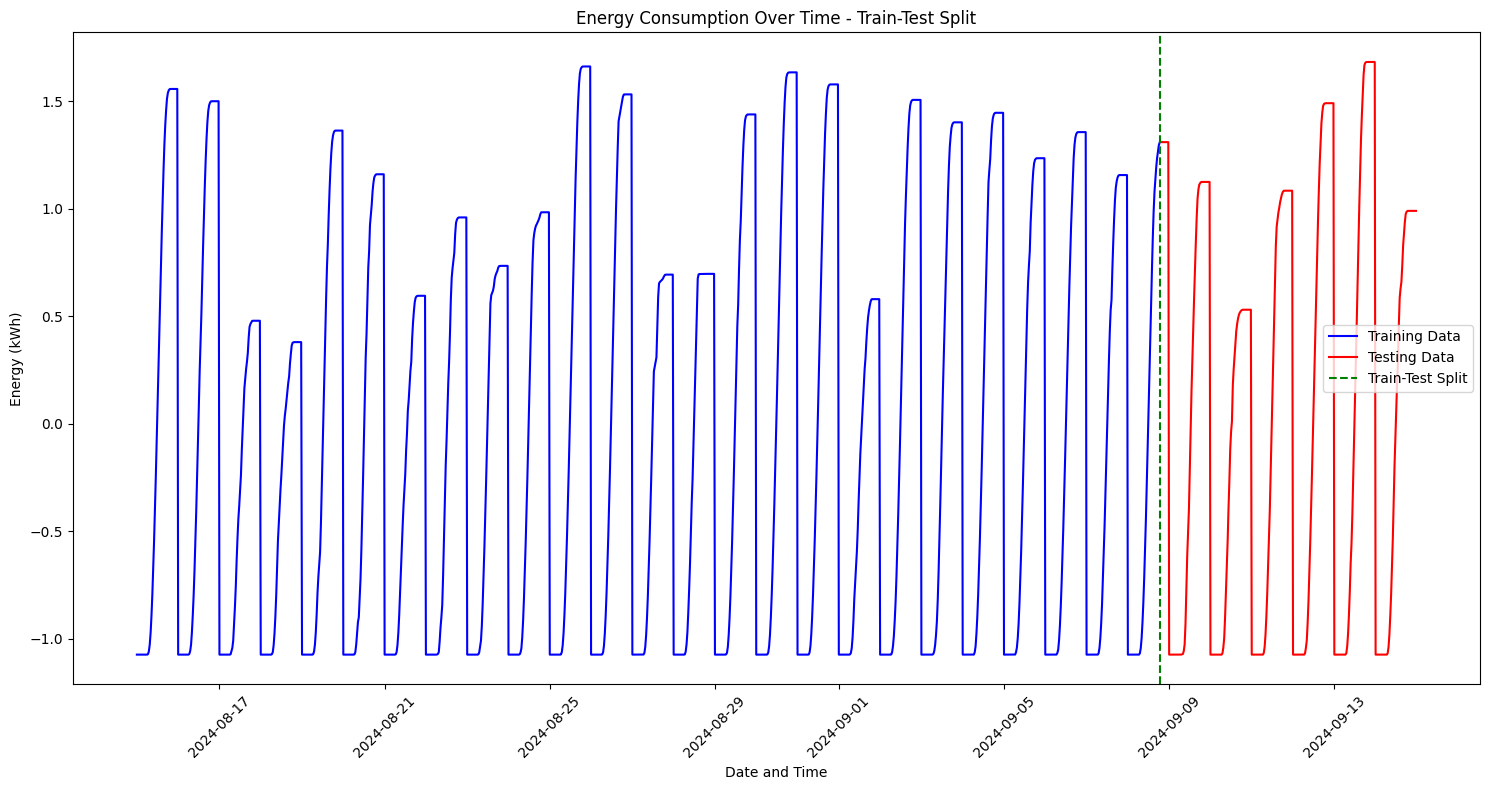

In [ ]:
plt.figure(figsize=(15, 8))

# Plot training data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')

# Plot testing data
plt.plot(test_data['ds'], test_data['y'], label='Testing Data', color='red')

# Add a vertical line to show the split point
split_date = train_data['ds'].iloc[-1]
plt.axvline(x=split_date, color='green', linestyle='--', label='Train-Test Split')

plt.title('Energy Consumption Over Time - Train-Test Split')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
# Initialize Prophet with appropriate parameters for 30-min data
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,  # custom seasonality
    seasonality_mode='additive',  # additive since data is scaled
    changepoint_prior_scale=0.01,  # Make it less flexible
    interval_width=0.95   #confidence interval
)

# Add custom daily seasonality
model.add_seasonality(
    name='daily',
    period=48,
    fourier_order=10  # more flexibile in daily pattern
)

# Add selected regressors
regressors = ['Power','Temperature', 'Energy Used', 'Voltage', 'Power Used']
for regressor in regressors:
    model.add_regressor(regressor)

# Fit the model
model.fit(train_data[['ds', 'y'] + regressors])

Model intialisation: Since the data are on 30 days scale, I will disable yearly seasonality and enable weekly and daily. 'additive' seasonality means seasonal patterns are added to the trend. Changepoint_pior_scale = 0.01 is set less flexbile in order to prevent overfitting. lastly, interval_width=0.95 sets the width of th confidence intervals for the forecast.

Custom Seasonality: period = 48 to capture a full day's seasonality as my data are on 30 interval. fourier_order = 10 provide more flexibility to accuretly model daily variations.

In [ ]:
future = model.make_future_dataframe(periods=len(test_data), freq='30min')

# Add regressor values to future dataframe
for regressor in regressors:
    future[regressor] = pd.concat([train_data[regressor], test_data[regressor]]).reset_index(drop=True)

# Make predictions
forecast = model.predict(future)

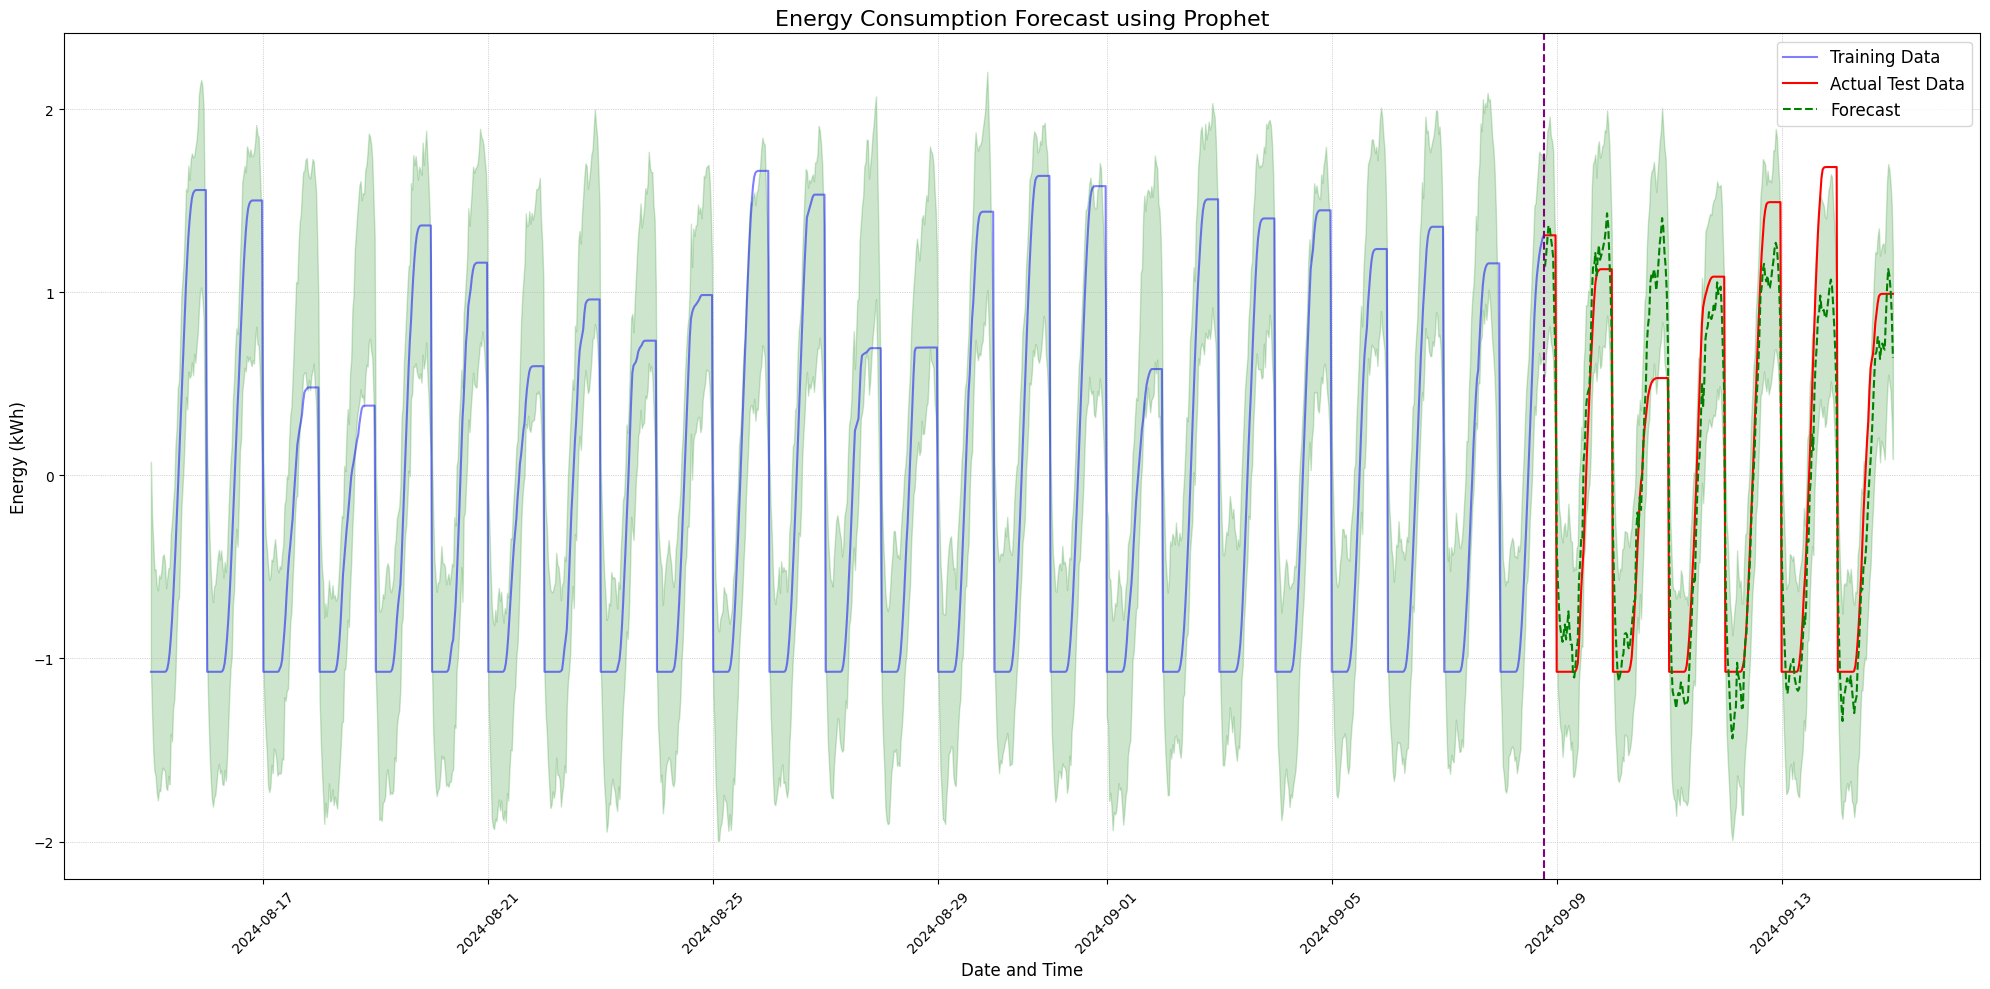

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue', alpha=0.5)
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='red')
test_forecast = forecast.iloc[-len(test_data):]
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast', color='green', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='green', alpha=0.2)

plt.title('Energy Consumption Forecast using Prophet', fontsize=16)
plt.legend(fontsize=12)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Add vertical line to show train-test split
split_date = train_data['ds'].iloc[-1]
plt.axvline(x=split_date, color='purple', linestyle='--', label='Train-Test Split')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate metrics for both training and test sets
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Training metrics
train_predictions = forecast[:len(train_data)]
train_metrics = calculate_metrics(train_data['y'], train_predictions['yhat'])

# Test metrics
test_predictions = forecast[-len(test_data):]
test_metrics = calculate_metrics(test_data['y'], test_predictions['yhat'])

print("Training Metrics:")
print(train_metrics)
print("\nTest Metrics:")
print(test_metrics)

Training Metrics:
{'MAE': 0.21227522169654642, 'RMSE': 0.2906827069310015, 'MAPE': 47.72468712599711}

Test Metrics:
{'MAE': 0.25861636411726857, 'RMSE': 0.33750341150760155, 'MAPE': 47.478211892648524}
